In [1]:
# necessary libraries for pre-processing
import utils
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Statistical Analysis

In [2]:
def get_col_max(df, col):
    '''Get the maximum value of a given column'''
    return df[col].max()

def get_col_min(df, col):
    '''Get the minimum value of a given column'''
    return df[col].min()

def get_col_count(df, col):
    '''Get the number of elements of a given column'''
    return df[col].count()

def get_col_avg(df, col):
    '''Get the average value of a given column'''
    return df[col].mean()

def get_col_std(df, col):
    '''Get the standar deviation value of a given column'''
    return df[col].std()

# Useful functions for preprocessing

In [3]:
def convert_date(df, column, date_format='%y%m%d'):
    '''Convert the given column containg dates in the given format
    to the standard date format and type'''
    copy_df = df.copy()
    copy_df[column] = pd.to_datetime(copy_df[column], format=date_format)

    return copy_df

In [4]:
def encode_column(df, column, options_list):
    '''Encode the given column of the given dataframe.
    All column values should be present in the options_list.'''
    copy_df = df.copy()

    le = preprocessing.LabelEncoder()
    le.fit(options_list)
    copy_df[column] = le.transform(copy_df[column])
    
    return copy_df

In [5]:
def normalize_columns(df, columns):
    '''Normalize the given columns for range between [0, 1]'''
    for col in columns:
        col_min = get_col_min(df, col)
        col_max = get_col_max(df, col)
        
        df[col] = (df[col] - col_min)/\
                    (col_max - col_min)

In [6]:
def get_df_correlation(df):
    '''Get the correlation between the dataframe features'''
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                     square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

In [7]:
def scatterplot_two_cols(df, col1, col2):
    '''Get a scatterplot for the given two columns'''
    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.scatterplot(data=df, x=col1, y=col2,
                    hue='status',palette=cmap, sizes=(47,47))
    plt.show()

## Imputation

In [8]:
def get_null_summary(dataset):
    '''Get a null summary display'''
    display(dataset.isnull().mean())

In [9]:
def clean_nulls(dataset, threshold=0.7):
    '''Clean nulls from the given table.
    If the nulls in a column are higher than the given threshold the entire column is deleted.
    If the nulls in a row are higher than the row, the row is also deleted.
    The threshold is a value between 0 and 1'''
    #Dropping columns with missing value rate higher than threshold
    dataset = dataset[dataset.columns[dataset.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    dataset = dataset.loc[dataset.isnull().mean(axis=1) < threshold]
    
    return dataset

In [10]:
def numerical_imputation(dataset, replacer=None):
    '''When null values exist, set them using the median of the colum,
    or a replacer, if one was given'''
    dataset = dataset.fillna(replacer if replacer else dataset.median())

    return dataset

In [11]:
def categorical_imputation(dataset, column_name, replacer=None):
    '''Replace the inexistent values of the given column with the given replacer.
    If None replacer was ginve, use the column maximum value'''
    #Max fill function for categorical columns
    dataset[column_name].fillna(replacer if replacer else \
                                dataset[column_name].value_counts()
                                                    .idxmax(),
                                inplace=True)
    
    return dataset

## Handling Outliers

In [12]:
def display_to_drop_std(dataset, column, mult_factor=3):
    '''Display the rows that will be dropped using the std approach'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_std(dataset, column, mult_factor=3):
    '''Drop the outlier rows with standard deviation'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    return dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

In [13]:
def display_to_drop_percentile(dataset, column):
    '''Display the rows that will be dropped with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_percentile(dataset, column):
    '''Drop the outlier rows with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    data = dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

## Binning

In [14]:
def numerical_binning(dataset):
    # TODO
    # https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
    return False

In [15]:
def categorical_binning(dataset):
    # TODO
    return False

# Feature Engineering

### For a first simpler approach, we will only use the 'loan' table

In [16]:
# Reading the different train tables
loan_df = utils.read_csv_to_df('competition_dataset/loan_train.csv', delimiter=';')
account_df = utils.read_csv_to_df('competition_dataset/account.csv', delimiter=';')
disp_df = utils.read_csv_to_df('competition_dataset/disp.csv', delimiter=';')
card_df = utils.read_csv_to_df('competition_dataset/card_train.csv', delimiter=';')


loan_test_df = utils.read_csv_to_df('competition_dataset/loan_test.csv', delimiter=';')
card_test_df = utils.read_csv_to_df('competition_dataset/card_test.csv', delimiter=';')

print(' ::: Tables Scheme :::')
print('\n\n\t LOAN TABLE')
display(loan_df.head())
print('\n\n\t ACCOUNT TABLE')
display(account_df.head())
print('\n\n\t DISPOSITION TABLE')
display(disp_df.head())
print('\n\n\t CREDIT CARD TABLE')
display(card_df.head())

 ::: Tables Scheme :::


	 LOAN TABLE


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1




	 ACCOUNT TABLE


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102




	 DISPOSITION TABLE


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT




	 CREDIT CARD TABLE


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215


 > Joint tables analysis


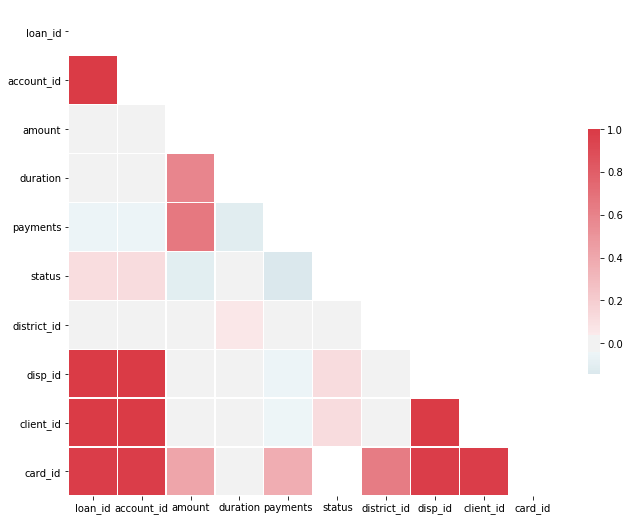

 > Since there is a correlation between the amount and duration, lets analyse it:


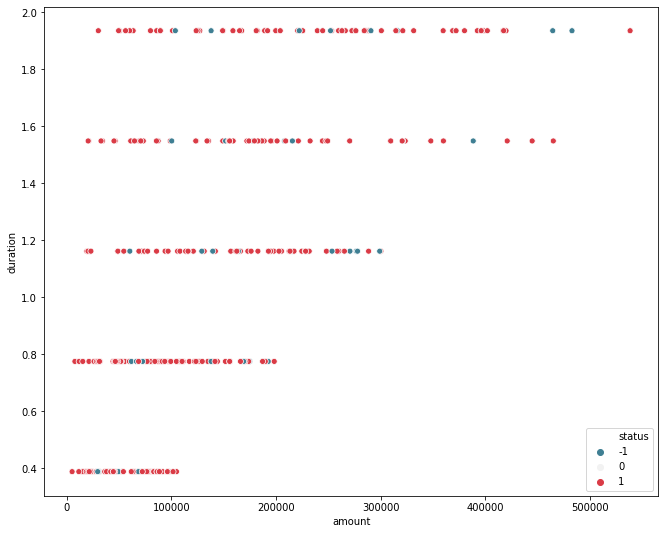

 > It is natural, since the larger the amount the more time the client has to expend it.
 > Since there is a correlation between the amount and payment, lets analyse it:


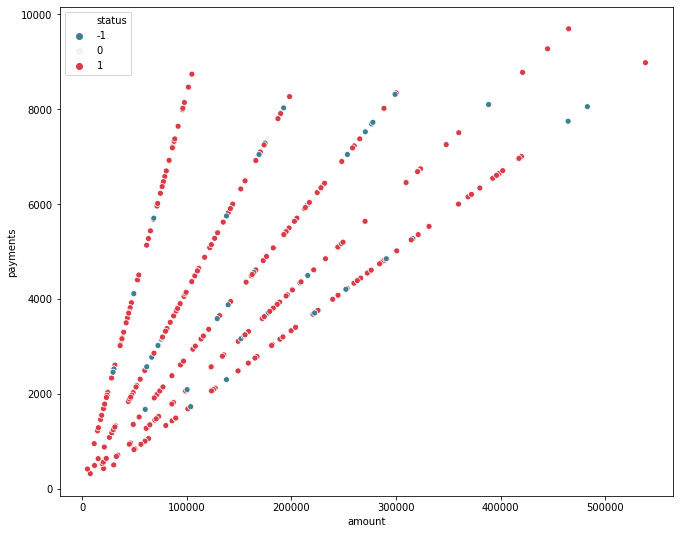

 > It is natural, since the larger the amount thelarger the monthly payment.


,date,amount,payments,account_loan_age,frequency_MI,frequency_WI,owners_count,C,monthly_loan,monthly_loan-to-monthly_receiving,monthly_only_receiving,status
0,0.000000,0.171345,0.823266,3.387097,0,1,1,0,0.823266,1.0,0.171345,-1
1,0.004721,0.301732,0.457951,4.774194,1,0,1,0,0.457951,1.0,0.301732,1
2,0.018096,0.228857,0.191996,5.483871,1,0,1,0,0.191996,1.0,0.228857,1
3,0.022817,0.188979,0.279616,5.967742,1,0,1,0,0.279616,1.0,0.188979,1
4,0.049567,0.505623,0.454642,6.580645,0,1,1,0,0.454642,1.0,0.505623,1
...,...,...,...,...,...,...,...,...,...,...,...,...
323,0.988198,0.282344,0.311953,22.290323,1,0,2,0,0.311953,1.0,0.282344,1
324,0.990559,0.407108,0.361153,12.322581,1,0,1,0,0.361153,1.0,0.407108,-1
325,0.995279,0.075056,0.066062,6.903226,1,0,1,0,0.066062,1.0,0.075056,1
326,0.998426,0.207737,0.309285,18.870968,1,0,1,0,0.309285,1.0,0.207737,1


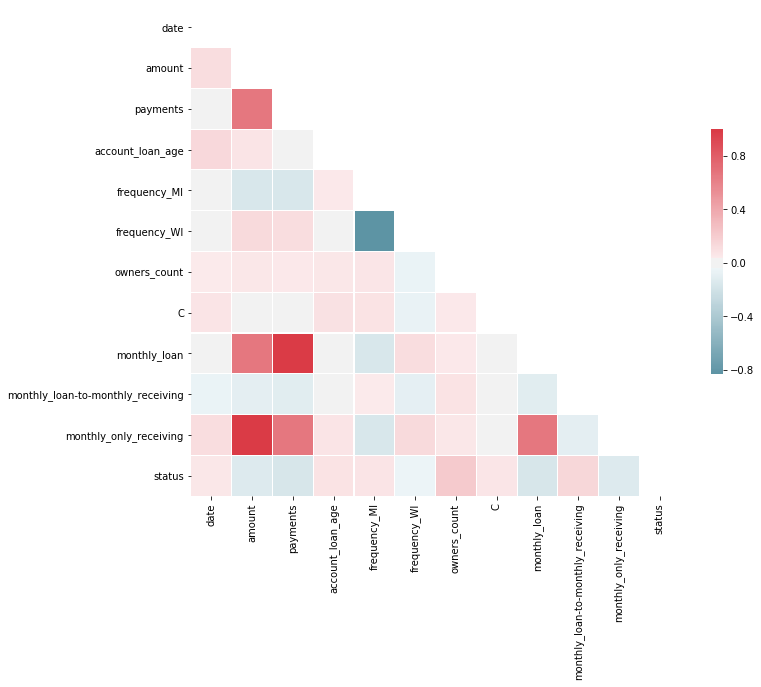

In [17]:
def compose_dataset(loan_df, account_df, disp_df, card_df, debug=False):
    '''Join the different tables and apply feature engineering'''

    # Creating formatted copy tables, so I can edit without changing original
    processed_loan = convert_date(loan_df, 'date')
    processed_account = convert_date(account_df, 'date')
    processed_disp = disp_df.copy()
    processed_card = convert_date(card_df, 'issued')
    
    # Renaming account attributes
    processed_account.loc[processed_account["frequency"]=="monthly issuance","frequency"] = "MI"
    processed_account.loc[processed_account["frequency"]=="weekly issuance","frequency"] = "WI"
    processed_account.loc[processed_account["frequency"]=="issuance after transaction","frequency"] = "IAT"
    
    # Renaming disp attributes
    processed_disp.loc[processed_disp["type"]=="OWNER","type"] = "O"
    processed_disp.loc[processed_disp["type"]=="DISPONENT","type"] = "U"
    
    # Renaming card attributes
    processed_card.loc[processed_card["type"]=="classic","type"] = "C"
    processed_card.loc[processed_card["type"]=="gold","type"] = "G"
    processed_card.loc[processed_card["type"]=="junior","type"] = "J"


    # Joining loan table, accounts table, disposition table & card table
    df = processed_loan.merge(processed_account.rename(columns={'date': 'account_creation_date'}),
                              on='account_id')\
                       .merge(processed_disp, on='account_id')\
                       .merge(processed_card.rename(columns={'type': 'card_type'}),
                              on='disp_id', how='left')
    
    if debug:
        print(' > Joint tables analysis')
        get_df_correlation(df)
    
    # Getting loanes age, in months & duration in months as well
    df['account_loan_age'] = (df['date'] - df['account_creation_date']).dt.days / 31
    df["date"] = pd.to_numeric(df["date"])
    df['duration'] = df['duration'] / 31

    # Separating categorial features
    df = pd.get_dummies(df)
    
    # Getting the Number of account owners & type of cards related to each account
    df_num_owners_and_types = df.groupby(
        ['loan_id', 'account_id']
    ).agg({
        'type_O': ['count'],
        'card_type_C': ['sum'],
        'card_type_G': ['sum'],
        'card_type_J': ['sum']
    }).reset_index()
    df_num_owners_and_types.columns = ['loan_id', 'acc', 'owners_count', 'C', 'G', 'J']
    df_num_owners_and_types = df_num_owners_and_types.drop(['acc'], axis=1)

    # Dropping useless columns
    df = df.drop(['account_creation_date', 'account_id', 'district_id',
                  'frequency_IAT', 'type_U', 'type_O', 'disp_id',
                  'client_id', 'card_id', 'issued', 'card_type_C',
                  'card_type_G', 'card_type_J'], axis=1)\
           .drop_duplicates()
    
    # Merging with the aggregattion results
    df = df.merge(df_num_owners_and_types, on='loan_id')
    df = df.drop(['J'], axis=1)

    # As there is a correlation between amount and duration
    if debug:
        print(' > Since there is a correlation between the amount and duration, lets analyse it:')
        scatterplot_two_cols(df, 'amount', 'duration')
        print(' > It is natural, since the larger the amount the more time the client has to expend it.')

        print(' > Since there is a correlation between the amount and payment, lets analyse it:')
        scatterplot_two_cols(df, 'amount', 'payments')
        print(' > It is natural, since the larger the amount thelarger the monthly payment.')
        
        
    # Create new columns: number of months it takes to pay payments
    df['num_payments'] = df['amount'] / df['payments']
    df['monthly_loan'] = df['amount'] / df['duration']
    df['months_of_receiving'] = df['num_payments'] - df['duration']
    df['monthly_loan-to-monthly_receiving'] = df['monthly_loan'] / df['payments']
    df['monthly_only_receiving'] = df['months_of_receiving'] * df['payments']
    
    # Duration is also naturally related to the amount, since larger amounts will be loaned for longer
   # scatterplot_two_cols(df, 'months_to_expend', 'num_payments')
    
    # Normalize numerical columns
    normalize_columns(df, ['amount', 'payments', 'date', 'monthly_loan',
                           'monthly_loan-to-monthly_receiving', 'monthly_only_receiving'])

    # Writing loan_id for later association on predictions
    utils.write_df_to_csv(
        df[['loan_id', 'date', 'amount']],
        'dataset', 'ids.csv')
    df = df.drop(['loan_id', 'duration', 'num_payments', 'months_of_receiving', 'G'], axis=1)

    # Placing status column as last column
    return  df[[col for col in df if col not in ['status']] + ['status']]


dataset = compose_dataset(loan_df, account_df, disp_df, card_df, debug=True)
display(dataset)
get_df_correlation(dataset)

In [18]:
# We should start 'cleansing' the data here
get_null_summary(dataset)

# for column in dataset:
    # display_to_drop_std(dataset, column)
    # display_to_drop_percentile(dataset, column)

date                                 0.0
amount                               0.0
payments                             0.0
account_loan_age                     0.0
frequency_MI                         0.0
frequency_WI                         0.0
owners_count                         0.0
C                                    0.0
monthly_loan                         0.0
monthly_loan-to-monthly_receiving    0.0
monthly_only_receiving               0.0
status                               0.0
dtype: float64

In [19]:
# Good tutorial for feature engineering:
# https://medium.com/datadriveninvestor/a-simple-guide-to-creating-predictive-models-in-python-part-1-8e3ddc3d7008

In [20]:
# Outputting the resultant table to a final csv
utils.write_df_to_csv(dataset, 'dataset', 'preprocessed_data.csv')
utils.write_df_to_csv(compose_dataset(loan_test_df, account_df, disp_df, card_test_df),
                      'dataset', 'test_dataset.csv')